# Depression Text Prediction

This project aims to predict whether a user feels depressed or not, based on the words used in the post.

Dataset source : <https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned>

Import the libraries

In [1]:
import re
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

Load the dataset

In [2]:
df = pd.read_csv("dataset/depression_dataset_reddit_cleaned.csv")
df.head(10)

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1
5,i m year old turning soon in a few month i liv...,1
6,i live alone and despite me being prone to lon...,1
7,i m not looking for sympathy just simply to st...,1
8,i don t know how to communicate all of my thou...,1
9,mom i m sad it hurt in my heart the feeling fa...,1


Shows the summary of the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_text     7731 non-null   object
 1   is_depression  7731 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.9+ KB


Check is there any missing values

In [4]:
df.isnull().sum()

clean_text       0
is_depression    0
dtype: int64

Check the class distribution

In [5]:
class_dist = df.groupby("is_depression").size()

for index, val in class_dist.iteritems():
    percentage = (val / sum(class_dist) * 100)
    print(f"Class {index} : {val} samples ({percentage:.2f}%)")

Class 0 : 3900 samples (50.45%)
Class 1 : 3831 samples (49.55%)


Create a function to preprocessing the data

In [6]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    return text

Apply preprocessing to the data

In [7]:
df["clean_text"] = df["clean_text"].apply(preprocessor)

Split the target and feature

In [8]:
X = df["clean_text"]
y = df["is_depression"]

Split the data into train and test set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

## Model Training

In [10]:
vectorizer = TfidfVectorizer()

In [11]:
model_list = [
    ('Decision Tree' , (Pipeline([('vectorizer' , vectorizer),('DT' ,DecisionTreeClassifier())]))),
    ('KNN' , (Pipeline([('vectorizer' , vectorizer),('KNN' ,KNeighborsClassifier())]))),
    ('Logistic Regression' , (Pipeline([('vectorizer' , vectorizer),('LR' ,LogisticRegression())]))),
    ('SVC' , (Pipeline([('vectorizer' , vectorizer),('SVC' ,SVC())]))),
    ('XGBoost' , (Pipeline([('vectorizer' , vectorizer),('XGB' ,XGBClassifier())])))
    ]

name_list = []
cv_mean_list = []
cv_std_list = []
kfold = KFold(n_splits=10)
for name, model in model_list:
    cv = cross_val_score(model , X_train ,y_train ,cv=kfold , scoring='accuracy', n_jobs=-1)
    name_list.append(name)
    cv_mean_list.append(cv.mean())
    cv_std_list.append(cv.std())
    print(f"{name} trained")

model_results = pd.DataFrame(list(zip(name_list, cv_mean_list, cv_std_list)), columns=['model', 'accuracy', 'stdev'])
model_results.round(3)

Decision Tree trained
KNN trained
Logistic Regression trained
SVC trained
XGBoost trained


,model,accuracy,stdev
0,Decision Tree,0.920,0.013
1,KNN,0.876,0.013
2,Logistic Regression,0.958,0.006
3,SVC,0.964,0.006
4,XGBoost,0.960,0.006


Create a pipeline of TfidVectorizer and SVC

In [12]:
clf_method = SVC()

clf = Pipeline([
     ('vectorizer', vectorizer),
     ('classifier', clf_method)
 ])

Fit the model

In [13]:
clf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('classifier', SVC())])

Predict the training set

In [14]:
y_train_pred = clf.predict(X_train)

Check the accuracy of the training set prediction

In [15]:
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Accuracy on training set: {train_accuracy:.3f}")

Accuracy on training set: 0.997


Shows the classification report of training set

In [16]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3117
           1       1.00      0.99      1.00      3067

    accuracy                           1.00      6184
   macro avg       1.00      1.00      1.00      6184
weighted avg       1.00      1.00      1.00      6184



Visualize the confusion matrix of the training set prediction

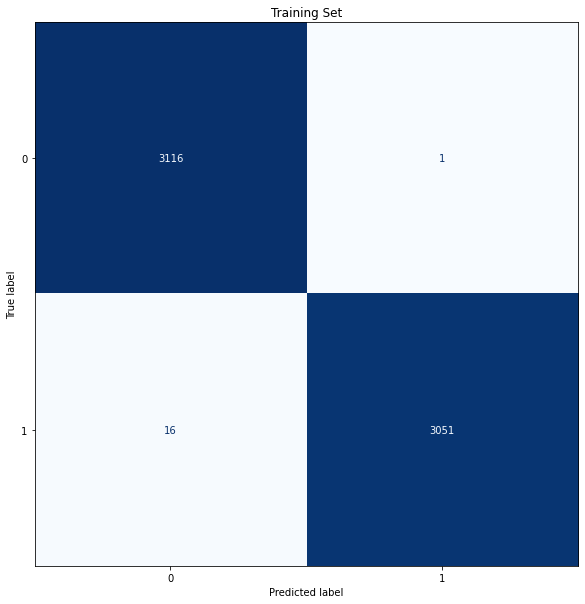

In [17]:
conf_mat_train = ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred))
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Training Set')
conf_mat_train.plot(cmap=plt.cm.Blues, colorbar=False, ax=ax);

## Model Evaluation

Predict the testing set

In [18]:
y_test_pred = clf.predict(X_test)

Check the accuracy of the testing set prediction

In [19]:
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on testing set: {test_accuracy:.3f}")

Accuracy on testing set: 0.962


Shows the classification report of testing set

In [20]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       783
           1       0.98      0.94      0.96       764

    accuracy                           0.96      1547
   macro avg       0.96      0.96      0.96      1547
weighted avg       0.96      0.96      0.96      1547



Visualize the confusion matrix of the testing set prediction

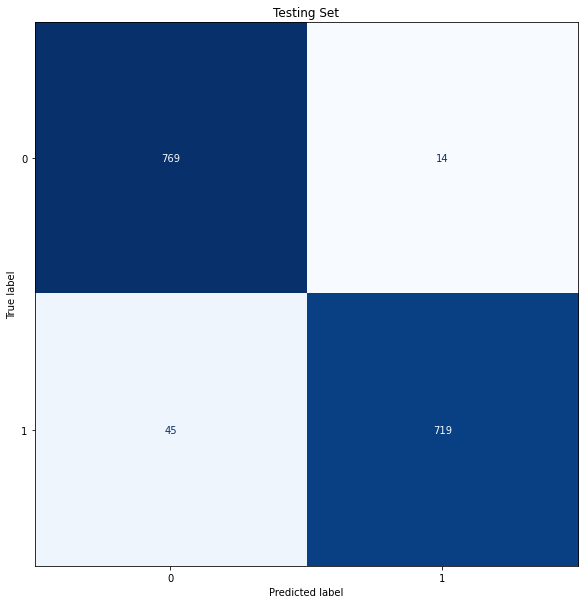

In [21]:
conf_mat_train = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred))
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Testing Set')
conf_mat_train.plot(cmap=plt.cm.Blues, colorbar=False, ax=ax);

## Save the model

In [22]:
import joblib

filename = "model/depression_prediction.sav"
joblib.dump(clf, filename)

['model/depression_prediction.sav']

## Conclusion